In [1]:
# Import libraries
import os
import random
import pickle
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud
import pickle
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
import nltk
#nltk.download('omw-1.4')
from scipy import sparse
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
from sklearn.decomposition import NMF
import gensim  # for word2vec
#from gensim.utils import simple_preprocess
#from gensim.parsing.preprocessing import STOPWORDS
#from gensim import corpora, models
#from gensim.models import CoherenceModel

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings('ignore')

In [ ]:
import sys
print(sys.executable)  # Python exe that's running
print(sys.version)  # Includes version
print(sys.version_info)  # Includes version major, minor, and micro
print(sys.prefix)  # Root of Python installation
#print(tensorflow.__version__)

# Data Collection

In [ ]:
# use praw (python reddit api wrapper) library to pull in reddit comments
# https://praw.readthedocs.io/en/stable/tutorials/comments.html
from secret import client_id, client_secret, user_agent
import praw

reddit_api = praw.Reddit(client_id=client_id,
                     client_secret=client_secret,
                     user_agent=user_agent)


In [ ]:
# scrape data from webpage
url = "https://www.reddit.com/r/AskReddit/comments/pqftho/what_is_the_best_advice_you_can_give_someone/"
submission = reddit_api.submission(url=url)

In [ ]:
# The submission forest contains a number of MoreComments objects (shown on site as "load more comments"/"continue this thread")
# use MoreComments to include these
from praw.models import MoreComments

comment_raw_list = []
counter = 0
# Calling replace_more() to access comments that are considered "more comments"
submission.comments.replace_more(limit=None)
for top_level_comment in submission.comments:
    print(top_level_comment.body)
    comment_raw_list.append(top_level_comment.body)


#print('There are {} number of top-level comments'.format(counter)) # using replace_more with no limit flattened top-level 
total_docs = len(comment_raw_list)
print(f"There are {total_docs} total documents.")

In [3]:
# Time to pickle!

# Store raw comment text
#with open('not_cleaned_text.pkl', 'wb') as f:
#    pickle.dump(comment_raw_list, f)

# Read it back in
with open('not_cleaned_text.pkl', 'rb') as f:
    comment_raw_list = pickle.load(f)

print(len(comment_raw_list))

1298


# Data Cleaning

In [ ]:
stop_words = list(set(stopwords.words("english"))) + ['dont', 'reddit', 'advice', 'never', 'must', 'should', 'getting', 'get',  'youre', 'put', 
                                                      'anything', 'thing', 'something', 'go', '', 'always']
cleaned_text = []

for i in range(len(comment_raw_list)):
    # Grab just the first sentence - advice normally in the first sentence and explained in further sentences
    comment = comment_raw_list[i].split(sep='.')[0]
    #print(f"Before cleaning: {comment} \n")
    comment = comment.split()
    # Remove punctuation
    new_comment = []
    for word in comment:
        word = re.sub(r"[^\w\w]", "", word)
        word = word.lower()
        new_comment.append(word)
    new_comment = [word for word in new_comment if word not in stop_words]
    # Lemmatize 
    new_comment = [WordNetLemmatizer().lemmatize(w) for w in new_comment]
    # Remove all text after an "edit:" phrase
    edit_ind = None
    for ind, word in enumerate(new_comment):
        if word == 'edit':
            edit_ind = ind
    if edit_ind is not None:
        del new_comment[edit_ind:]  # remove all words at and after that index
    if new_comment != '':
        cleaned_text.append(new_comment)
    #print(f"After cleaning: {new_comment} \n\n\n")

In [4]:
# Time to pickle!

# Store cleaned text
#with open('cleaned_text_v2.pkl', 'wb') as f:
#    pickle.dump(cleaned_text, f)

# Read it back in
with open('cleaned_text_v2.pkl', 'rb') as f:
    cleaned_text = pickle.load(f)

print(len(cleaned_text))
print(cleaned_text[:20])

1298
[['take', 'care', 'teeth', 'body', 'young'], ['young', 'immature', 'forever'], ['careful', 'kid'], ['responsible'], ['hard', 'sometimes', 'life', 'get', 'complicated', 'fault', 'best', 'every', 'situation', 'let', 'thing'], ['imagine', 'time', 'spend', 'worrying', 'embarrassing', 'moment'], ['anyone', 'pedestal', 'choice', 'look'], ['stuff', 'stuff', 'owns'], ['listen', 'random', 'stranger', 'internet'], ['sex', 'worth', 'torment', 'sharing', 'child', 'someone', 'end', 'despising'], ['like', 'doesnt', 'mean', 'inherently', 'bad'], ['take', 'advantage', 'health', 'insurance'], ['stay', 'late', 'would', 'wake', 'early'], ['stay', 'debt'], ['choose', 'life', 'partner', 'wisely'], ['smoke'], ['want'], ['try'], ['treat', 'someone', 'trying', 'help'], ['take', 'responsibility', 'action']]


In [5]:
# Remove cleaned text with 0 words (after cleaning some examples had 0 words)
cleaned_text = [text for text in cleaned_text if len(text) > 0]
len(cleaned_text)  # 8 comments with zero words removed

1278

# Data Exploration

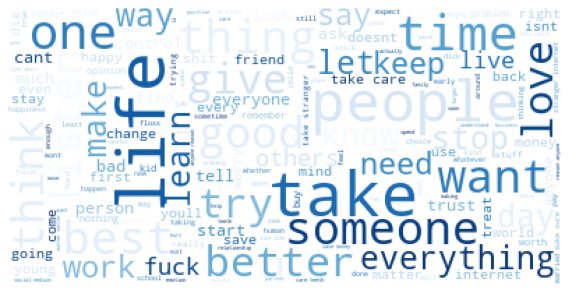

In [5]:
# Word cloud - Check most common words
plt.rcParams["figure.figsize"] = (10,10)
wc = WordCloud(background_color='white', max_font_size=48, colormap='Blues_r')

wc_str = ' '.join([' '.join(txt) for txt in cleaned_text])  # Create string from list
wc.generate(wc_str)
plt.imshow(wc)
plt.axis('off')
plt.show()

# In article talk about how you can guess a few of the topics based on the words in the word cloud.

Minimum # of words in a post: 1 
Maximum # of words in a post: 106 
Average # of words in a post: 4.604851330203443


(array([1.219e+03, 5.500e+01, 2.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([  1. ,  11.5,  22. ,  32.5,  43. ,  53.5,  64. ,  74.5,  85. ,
         95.5, 106. ]),
 <BarContainer object of 10 artists>)

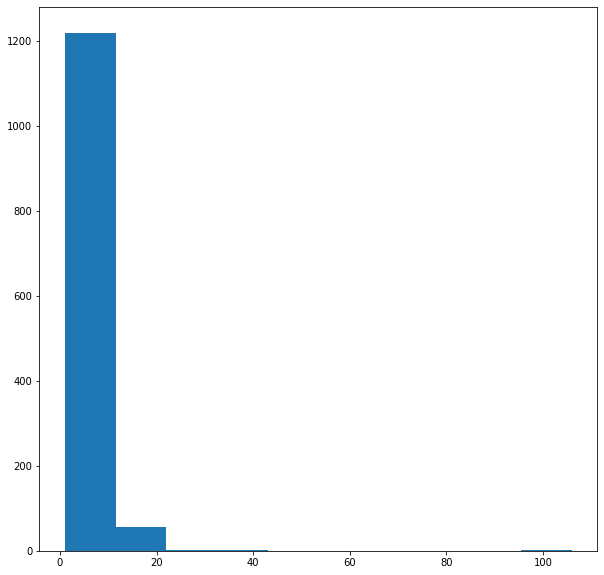

In [6]:
# Find the min and max word count & remove posts with 0 words after cleaning steps
word_counts = [len(words) for words in cleaned_text] 
print(f"Minimum # of words in a post: {min(word_counts)} \nMaximum # of words in a post: {max(word_counts)} \nAverage # of words in a post: {sum(word_counts)/len(word_counts)}")

# Show distribution of word count
plt.hist(word_counts)

# Prep Data for LDA and NMF

Used CountVectorizer for LDA and TF-IDF for NMF.

In [6]:
# Prep data for vectorizer (change list of lists to a list of sentences)
cleaned_text_transformed = [' '.join(list) for list in cleaned_text]

In [7]:
# Create Count vectorizer for LDA
vectorizer_count = CountVectorizer(#max_df=0.75, # ignore terms that appear in X% of docs
                             min_df=2,  # ignore terms that appear in less than 2 documents
                             ngram_range=(1,2)  # allow bigrams
                                )

X_count = vectorizer_count.fit_transform(cleaned_text_transformed)
X_count.shape

(1278, 1005)

In [8]:
# Create TF-IDF vectorizer for NVM
vectorizer_tfidf = TfidfVectorizer(#max_df=0.75,  # ignore terms that appear in X% of docs
                             min_df=2,  # ignore terms that appear in less than 2 documents
                             #ngram_range=(1,2)  # allow bigrams
                               )

X_tfidf = vectorizer_tfidf.fit_transform(cleaned_text_transformed)
X_tfidf.shape

(1278, 726)

# LDA

In [ ]:
# Find good number of topics and other parameters using sklearn's gridsearch function
#https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/#11howtogridsearchthebestldamodel
from sklearn.model_selection import GridSearchCV

# Define Search Param
search_params = {'n_components': [5, 10, 15, 20, 25, 30], 
                 'learning_method': ['online', 'batch'], 
                 'learning_decay': [0.4, 0.5, 0.7, 0.9],
                 'max_iter': [20, 50, 100, 120]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(X_count)

# Print best model
best_lda_model = model.best_estimator_
best_lda_model

# Scored using Log likelihood - the lower, the better.
# Max Iter default is 200, will keep default as higher seems to perform better.

In [9]:
# Create lda model
lda_model = LatentDirichletAllocation(n_components=6, 
                                        learning_method='online',
                                        learning_decay=0.9)

lda_model_results = lda_model.fit_transform(X_count)

In [11]:
# Grab top 20 words for each topic
for index, topic in enumerate(lda_model.components_):
    print(f"The top 20 words for topic # {index}")
    print([vectorizer_count.get_feature_names()[i] for i in topic.argsort()[-20:]])
    print("\n")

The top 20 words for topic # 0
['ask', 'control', 'shit', 'like', 'trust', 'money', 'much', 'save', 'others', 'live', 'work', 'better', 'way', 'stop', 'one', 'want', 'thing', 'people', 'think', 'life']


The top 20 words for topic # 1
['love', 'happiness', 'use', 'people', 'tell', 'enough', 'else', 'fuck', 'happy', 'youll', 'stuff', 'sure', 'look', 'take', 'right', 'find', 'keep', 'life', 'make', 'someone']


The top 20 words for topic # 2
['nothing', 'ever reason', 'stranger internet', 'every', 'take stranger', 'going', 'let', 'life', 'bad', 'person', 'anyone', 'like', 'internet', 'reason', 'ever', 'stranger', 'try', 'give', 'matter', 'best']


The top 20 words for topic # 3
['help', 'stick', 'invest', 'sunscreen', 'trying', 'early', 'cant', 'say', 'start', 'kid', 'need', 'wear', 'dick', 'people', 'time', 'day', 'stay', 'love', 'learn', 'listen']


The top 20 words for topic # 4
['decision', 'twice', 'probably', 'yellow', 'yellow snow', 'eat yellow', 'sleep', 'brush', 'snow', 'daily',

In [10]:
# Visualize the topics
import pyLDAvis.sklearn as LDAvis
import pyLDAvis
pyLDAvis.enable_notebook()


panel = LDAvis.prepare(lda_model, X_count, vectorizer_count)
panel

# To save Pyldavis topic info
#panel.topic_info

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.162304 -0.115285       1        1  19.922595
3      0.122699  0.086264       2        1  18.653554
5     -0.117277  0.119373       3        1  17.314734
2     -0.035386  0.113372       4        1  16.846802
1      0.032050 -0.166627       5        1  15.354848
0      0.160218 -0.037098       6        1  11.907466, topic_info=       Term       Freq      Total Category  logprob  loglift
482    life  86.000000  86.000000  Default  30.0000  30.0000
497  listen  26.000000  26.000000  Default  29.0000  29.0000
595     one  39.000000  39.000000  Default  28.0000  28.0000
942    want  32.000000  32.000000  Default  27.0000  27.0000
874   think  40.000000  40.000000  Default  26.0000  26.0000
..      ...        ...        ...      ...      ...      ...
951   water   4.427881   7.242459   Topic6  -5.0026   1.6360
627  people  12.601898  61.324161   Topic6  -3.9566   0.5457
558   money   7.466922  21.808208   Topic6  -4.4800   1.0562
477     let   5.042278  23.856150   Topic6  -4.8726   0.5738
342     get   4.336419  11.601435   Topic6  -5.0234   1.1439

[317 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
0         1  0.897966        10
5         1  0.781517        30
12        1  0.148237  actually
12        4  0.741183  actually
18        6  0.723005    advice
...     ...       ...       ...
1000      4  0.922021     youll
1002      1  0.241928     young
1002      4  0.564498     young
1002      5  0.161285     young
1003      1  0.929401     youve

[412 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 6, 3, 2, 1])

# NMF

In [47]:
# Build NMF model
nmf_model = NMF(n_components=6)
nmf_model.fit(X_tfidf)

NMF(n_components=6)

In [48]:
# Grab top 20 words for each topic
for index, topic in enumerate(nmf_model.components_):
    print(f"The top 20 words for topic # {index}")
    print([vectorizer_tfidf.get_feature_names()[i] for i in topic.argsort()[-20:]])
    print("\n")

The top 20 words for topic # 0
['alive', 'away', 'serious', 'stranger', 'people', 'careful', 'first', 'action', 'responsibility', 'wouldnt', 'criticism', 'learn', 'health', 'seriously', 'anyone', 'someone', 'time', 'teeth', 'care', 'take']


The top 20 words for topic # 1
['enjoy', 'important', 'serious', 'like', 'rush', 'people', 'best', 'toxic', 'whatever', 'try', 'fuck', 'drug', 'say', 'happy', 'fullest', 'want', 'better', 'short', 'live', 'life']


The top 20 words for topic # 2
['smart', 'giving', 'want', 'job', 'none', 'business', 'everything', 'worrying', 'say', 'fuck', 'give', 'believe', 'care', 'way', 'caring', 'much', 'others', 'stop', 'people', 'think']


The top 20 words for topic # 3
['forum', 'like', 'random', 'talking', 'wear', 'talk', 'older', 'process', 'music', 'gut', 'actually', 'unsolicited', 'else', 'le', 'anyones', 'others', 'advice', 'say', 'give', 'listen']


The top 20 words for topic # 4
['make', 'else', 'everything', 'ever', 'know', 'reason', 'like', 'control

In [ ]:
# Time to pickle!
#with open('nmf_model.pkl', 'wb') as f:
#    pickle.dump(nmf_model, f)

# Read it back in
with open('nmf_model.pkl', 'rb') as f:
    nmf_model = pickle.load(f)


Both LDA and NMF topic results did not produce very clean topics where I would want to rely on them to label comments, but the results were still used to develop the main topic themes along with a starting point for terms within each topic.
Will build onto these results by cherry picking the terms that made the most sense for topic theme then finding related
terms using a pre-trained word2vec model to enhance the term list for each topic. 

Below are the topics I made from the results of the best LDA model. I also read through the comments and believe all comments could fit into one of these
topics.
1. Physical Health
2. Mental Health
3. Interpersonal Relationships
4. Love life (marriage, dating)
5. Financial
5. General Responsible decisions/Life Planning

# Create model with Output + Word2vec enhancement

LDA and NMF did not produce clear results. Instead of using either model, I used the results as an exploratory method rather than the final labeling technique. I gathered the main topics mentioned above and cherry picked words that fit. Using Google's pretrained word2vec model, I will add to the list of words for each topic. Need to add a way to determine assignment...based on count or based on prob from related word.

In [15]:
# Load in pre-trained word2vec model
#w2v_model = Word2Vec(cleaned_text, min_count=1,size= 50,workers=3, window =3, sg = 1)  # This would train my own
w2v_model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)  

In [26]:
# Create dictionary of topics and associated words that were cherry picked from the topic modeling results
topic_keyword_dict = {}
topic_keyword_dict = {"Physical Health": ["physical", "health", "sunscreen", "teeth", "eat", "body", "food", "smoke"],			
"Mental Health": ["trust", "reason", "learn", "believe", "care", "mental", "smile", "focus", "hope", "emotion"],
"Interpersonal Relationships" : ["others", "people", "everyone", "someone", "family", "friend", "stranger", "neighbor"],			
"Love" : ["married", "marriage", "dating", "single", "love", "partner", "gay"],	
"Financial" : ["save", "money", "credit", "invest", "retirement", "ira", "buy", "gamble"],				
"Life Planning" : ["responsibility", "time", "try", "life", "reasonable", "career", "job", "degree", "college", "study", "achieve", "intentional", "goal", "far", "future", "die", "death", "focus", "plan", "decide"]}

topic_list = [key for key,val in topic_keyword_dict.items()] + ['Other']  # Using 'Other' as a placeholder in case I want to have a 'leftover' bucket.
topic_list

['Physical Health',
 'Mental Health',
 'Interpersonal Relationships',
 'Love',
 'Financial',
 'Life Planning',
 'Other']

In [ ]:
# Saving the original topic_keyword_dict before adding more keywords after viewing the results
#with open('topic_keyword_dict_og.pkl', 'wb') as f:
#    pickle.dump(topic_keyword_dict, f)

# Read it back in
#with open('topic_keyword_dict_og.pkl', 'rb') as f:
#    topic_keyword_dict_og = pickle.load(f)

In [ ]:
# Find most similar words
# Positive words contribute positively towards the similarity, negative words negatively.
#w2v_model.most_similar(positive=["goal", "plan"], negative=["sports"])
add_words = w2v_model.most_similar(positive=["stress", "health"], negative=["mental"])
#print(add_words)
for tup in add_words:
    word = tup[0]
    print(word)

In [ ]:
# Notes on how to add similar words to build the dictionary
# ----------- Physical Health
# (positive=["physical", "body", "health"], negative=["mental", "person"])
# (positive=["health"])
# (positive=["sunscreen"])
# (positive=["teeth", "health"])
# (positive=["eat", "nutrition"])
# (positive=["body", "healthy"])
# (positive=["exercising", "health"])

# ----------- Mental Health
# (positive=["trust", "emotion"])
# (positive=["reason", "thinking"])
# (positive=["learn", "educate"])
# (positive=["believe"])
# (positive=["care", "emotion"])
# (positive=["mental", "health"])
# (positive=["smile", "happy"])
# (positive=["focus", "think"])
# (positive=["hope", "emotion"])
# (positive=["emotion"])

# ----------- Interpersonal Relationships
# (positive=["others", "people"])
# (positive=["people"])
# (positive=["everyone"])
# (positive=["someone"])
# (positive=["family"])
# (positive=["friend"], negative=["love"])
# (positive=["neighbor", "person"]) subtract woman, man they are usually used in love life advice

# ----------- Love
# (positive=["married"])
# (positive=["marriage"])
# (positive=["date", "romantic"])
# (positive=["single", "dating"], negative=["website"])
# (positive=["love"])
# (positive=["partner", "wife"])
# (positive=["gay", "dating"])

# ----------- Financial
# (positive=["save", "money", "funds"])
# (positive=["money"])
# (positive=["credit"])
# (positive=["invest"])
# (positive=["retirement", "money"], negative=[])

# ----------- Life Planning
# (positive=["responsibility"])
# (positive=["time", "lifetime"])
# (positive=["try"])
# (positive=["life"], negative=["person"])
# (positive=["reasonable"], negative=["unreasonable"])
# (positive=["career", "job"], negative=["resume"])
# (positive=["intentional", "plan"], negative=["unintentional"])
# (positive=["goal", "plan"], negative=["sports"])

In [17]:
# Store the paramters found from the previous step
additional_words_param_dict = {
 "Physical Health" : {
     "physical" : {"positive" : ["physical", "body", "health"], "negative":["mental", "person"]},
     "health" : {"positive":["health"]},
     "sunscreen" : {"positive":["sunscreen"]},
     "teeth" : {"positive":["teeth", "health"]},
     "eat" : {"positive":["eat", "nutrition"]},
     "body" : {"positive":["body", "healthy"]},
     "exercise" : {"positive":["exercising", "health"]}},
 "Mental Health" : {
     "trust" : {"positive": ["trust", "emotion"]},
     "reason" : {"positive": ["reason", "thinking"]},
     "learn" : {"positive": ["learn", "educate"]},
     "believe" : {"positive": ["believe"]},
     "care" : {"positive": ["care", "emotion"]},
     "mental" : {"positive": ["mental", "health"]},
     "smile" : {"positive": ["smile", "happy"]},
     "focus" : {"positive": ["focus", "think"]},
     "hope" : {"positive": ["hope", "emotion"]},
     "emotion" : {"positive": ["emotion"]}
 },
 "Interpersonal Relationships" : {
     "others": {"positive": ["others", "people"]},
     "people": {"positive": ["people"]},
     "everyone": {"positive": ["everyone"]},
     "someone": {"positive": ["someone"]},
     "family": {"positive": ["family"]},
     "friend": {"positive": ["friend"], "negative": ["love"]},
     "stranger": {"positive": ["stranger"], "negative": ["gender"]},
     "neighbor": {"positive": ["neighbor", "person"]}
 },
 "Love" : {
     "married": {"positive": ["married"]},
     "marriage": {"positive": ["marriage"]},
     "dating": {"positive": ["date", "romantic"]},
     "single": {"positive": ["single", "dating"], "negative": ["website"]},
     "love": {"positive": ["love"]},
     "partner": {"positive": ["partner", "wife"]},
     "gay" : {"positive": ["gay", "dating"]}  # "Gay" gave better results than "Homosexuality"
 },
 "Financial" : {
     "save": {"positive": ["save", "money", "funds"]},
     "money": {"positive": ["money"]},
     "credit": {"positive": ["credit"]},
     "invest": {"positive": ["invest"]},
     "retirement": {"positive": ["retirement", "money"]}
 },
 "Life Planning" : {
     "responsibility": {"positive": ["responsibility"]},
     "time": {"positive": ["time", "lifetime"]},
     "try": {"positive": ["try"]},
     "life": {"positive": ["life"], "negative": ["person"]},
     "reasonable": {"positive": ["reasonable"], "negative": ["unreasonable"]},
     "career": {"positive": ["career", "job"], "negative": ["resume"]},
     "intentional": {"positive": ["intentional", "plan"], "negative": ["unintentional"]},
     "goal": {"positive": ["goal", "plan"], "negative": ["sports"]}
     
 }
                               }
print(additional_words_param_dict)

{'Physical Health': {'physical': {'positive': ['physical', 'body', 'health'], 'negative': ['mental', 'person']}, 'health': {'positive': ['health']}, 'sunscreen': {'positive': ['sunscreen']}, 'teeth': {'positive': ['teeth', 'health']}, 'eat': {'positive': ['eat', 'nutrition']}, 'body': {'positive': ['body', 'healthy']}, 'exercise': {'positive': ['exercising', 'health']}}, 'Mental Health': {'trust': {'positive': ['trust', 'emotion']}, 'reason': {'positive': ['reason', 'thinking']}, 'learn': {'positive': ['learn', 'educate']}, 'believe': {'positive': ['believe']}, 'care': {'positive': ['care', 'emotion']}, 'mental': {'positive': ['mental', 'health']}, 'smile': {'positive': ['smile', 'happy']}, 'focus': {'positive': ['focus', 'think']}, 'hope': {'positive': ['hope', 'emotion']}, 'emotion': {'positive': ['emotion']}}, 'Interpersonal Relationships': {'others': {'positive': ['others', 'people']}, 'people': {'positive': ['people']}, 'everyone': {'positive': ['everyone']}, 'someone': {'positive

In [32]:
# Create a dictionary for the enhanced keywords by topic
enhanced_keyword_dict = {}
for topic in topic_list:
    if topic != "Other":  # Skip the last topic, "Other" since it does not have any associated words
        enhanced_keyword_dict[topic] = {
            "words" : topic_keyword_dict[topic]
        }
    else:
        enhanced_keyword_dict[topic] = {"words" : []}

print(enhanced_keyword_dict)

{'Physical Health': {'words': ['physical', 'health', 'sunscreen', 'teeth', 'eat', 'body', 'food', 'smoke']}, 'Mental Health': {'words': ['trust', 'reason', 'learn', 'believe', 'care', 'mental', 'smile', 'focus', 'hope', 'emotion']}, 'Interpersonal Relationships': {'words': ['others', 'people', 'everyone', 'someone', 'family', 'friend', 'stranger', 'neighbor']}, 'Love': {'words': ['married', 'marriage', 'dating', 'single', 'love', 'partner', 'gay']}, 'Financial': {'words': ['save', 'money', 'credit', 'invest', 'retirement', 'ira', 'buy', 'gamble']}, 'Life Planning': {'words': ['responsibility', 'time', 'try', 'life', 'reasonable', 'career', 'job', 'degree', 'college', 'study', 'achieve', 'intentional', 'goal', 'far', 'future', 'die', 'death', 'focus', 'plan', 'decide']}, 'Other': {'words': []}}


In [34]:
# Add additional keywords to the topics using the most_similar method
# Iterate through the topics, find their words and match for words in the additional words dict, then add their top similar 
# words using the paramters in the additional_words_param_dict
# Topic -> word -> vector value and keep only distinct values
for topic in topic_list[:len(topic_list)-1]:
    for topic_add in additional_words_param_dict[topic]:
        pos_param = additional_words_param_dict[topic][topic_add]["positive"]
        if "negative" in additional_words_param_dict[topic][topic_add].keys():
            neg_param = additional_words_param_dict[topic][topic_add]["negative"]
        else:
            neg_param = []   
        add_words = w2v_model.most_similar(positive=pos_param, negative=neg_param)
        words = [tup[0] for tup in add_words]
        enhanced_keyword_dict[topic]["words"] += words
        enhanced_keyword_dict[topic]["words"] = list(set(enhanced_keyword_dict[topic]["words"]))

print(enhanced_keyword_dict)

{'Physical Health': {'words': ['abscessed_teeth', 'physiologic_fluids', 'helath', 'smoke', 'suncream', 'abdominal_visceral_fat', 'Proper_nutrition', 'heatlh', 'Health', 'heathy', 'flushes_toxins', 'heath_care', 'sunscreen_lotion', 'lameness_lesions_dehydration', 'Asadullah_Sherzad', 'dental', 'healthly', 'healthier', 'heath', 'sunscreens', 'exercise', 'health_care', 'food', 'health', 'nutritional', 'healthcare', 'tooth', 'sunscreen', 'teeth', 'WholeCamels_Bad_sign', 'cardio_respiratory_fitness', 'suntan_lotion', 'eat', 'waterproof_sunscreen', 'nutrition', 'eat_healthfully', 'nutritionally_sound', 'Eating_healthily', 'Exercising', 'eat_nutritiously', 'lubricate_joints', 'wellness', 'aerobically_fit', '2_wks_Vac', 'nutritiously', 'diet', 'healty', 'balanced_diet', 'eating_nutritious_foods', 'fitting_dentures', 'sunblock', 'exercised', 'SPF_sunscreen', 'basal_metabolism', 'benefits_Ekblom_Bak', 'physical', 'respiratory_circulatory', 'nutritious', 'insect_repellant', 'ate_healthily', 'bodi

In [42]:
##### NOTES #####
# Example on finding vector values for words
#sentence = ["save", "money", "funds"]
#vectors = [w2v_model[w] for w in sentence]
#print(vectors)

# Try out similarity for both meanings of the word "bank". 
add_words = w2v_model.most_similar(positive=["goal", "plan"], negative=["sports"])
#print(add_words)
for tup in add_words:
    word = tup[0]
    print(word)
    
# To find similarity (cosine similarity)
#w2v_model.similarity("ira", "fun")

goals
plans
strategy
proposal
blueprint
effort
roadmap
stategy
objectives
aim


In [ ]:
# Time to pickle!
# Store enhanced keyword list
#with open('enhanced_keyword_dict.pkl', 'wb') as f:
#    pickle.dump(enhanced_keyword_dict, f)

# Read it back in
with open('enhanced_keyword_dict.pkl', 'rb') as f:
    enhanced_keyword_dict = pickle.load(f)

In [28]:
# Graph original keywords and similarities (colored by topic) to view closeness between topics & add their word2vec values
topics = []
words = []
vecs = []

for topic in topic_keyword_dict.keys():
    for i in range(len(topic_keyword_dict[topic])):
        topics.append(topic)
        words.append(topic_keyword_dict[topic][i])
        vecs.append(w2v_model[topic_keyword_dict[topic][i]])


og_words_df = pd.DataFrame()
og_words_df['Topic'] = topics
og_words_df['Word'] = words
og_words_df['Value'] = vecs
print(og_words_df.head())

             Topic       Word  \
0  Physical Health   physical   
1  Physical Health     health   
2  Physical Health  sunscreen   
3  Physical Health      teeth   
4  Physical Health        eat   

                                               Value  
0  [-0.06640625, 0.107421875, -0.19921875, 0.0016...  
1  [-0.07421875, 0.11279297, 0.09472656, 0.071777...  
2  [-0.16015625, -0.15722656, 0.19921875, -0.0060...  
3  [0.05493164, 0.07861328, 0.14550781, -0.3125, ...  
4  [-0.15722656, -0.107421875, -0.03149414, 0.478...  


In [29]:
# Squish vectors to 2 components for graphing
tnse_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=199)
squished_vals = tnse_model.fit_transform(list(og_words_df['Value']))

In [30]:
og_words_df

,Topic,Word,Value
0,Physical Health,physical,"[-0.06640625, 0.107421875, -0.19921875, 0.0016..."
1,Physical Health,health,"[-0.07421875, 0.11279297, 0.09472656, 0.071777..."
2,Physical Health,sunscreen,"[-0.16015625, -0.15722656, 0.19921875, -0.0060..."
3,Physical Health,teeth,"[0.05493164, 0.07861328, 0.14550781, -0.3125, ..."
4,Physical Health,eat,"[-0.15722656, -0.107421875, -0.03149414, 0.478..."
...,...,...,...
56,Life Planning,die,"[0.100097656, 0.17578125, 0.043701172, 0.40625..."
57,Life Planning,death,"[-0.044677734, 0.057128906, 0.328125, 0.062988..."
58,Life Planning,focus,"[0.07714844, 0.16015625, 0.07080078, 0.0109863..."
59,Life Planning,plan,"[0.07861328, 0.09814453, 0.16894531, 0.0834960..."


<AxesSubplot:title={'center':'Original keywords from Topic Modeling'}, xlabel='PC2', ylabel='PC1'>

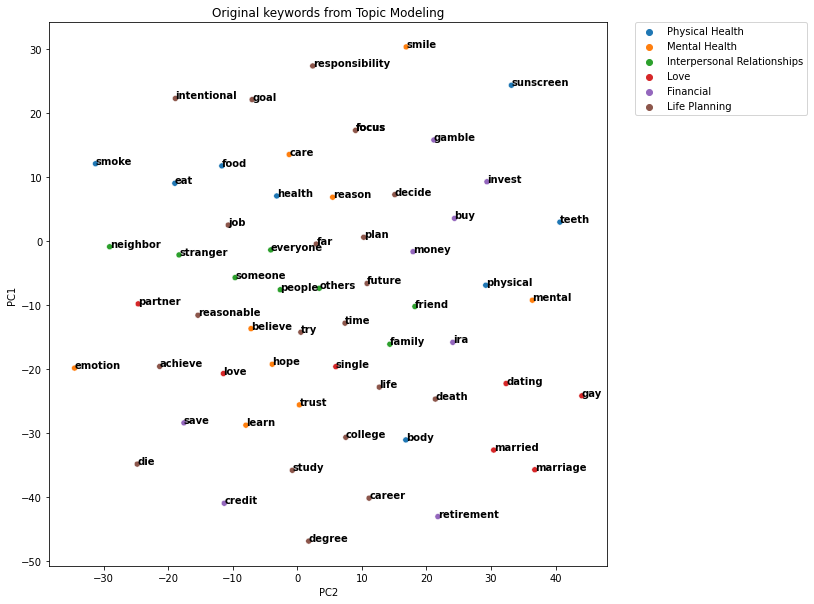

In [31]:
# Graph all keywords and similarities (colored by topic) to view closeness between topics
squished_vals
x = [val[0] for val in squished_vals]
y = [val[1] for val in squished_vals]
labels = og_words_df['Word']
col_cat = og_words_df['Topic']

plt.rcParams["figure.figsize"] = (10,10)
plt1 = sns.scatterplot(x, y, hue=col_cat)
for i in range(len(labels)):
    plt1.text(x[i]+0.01, y[i], labels[i], horizontalalignment="left", size="medium", color="black", weight="semibold")

plt.title("Original keywords from Topic Modeling")
plt.xlabel("PC2")
plt.ylabel("PC1") 
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt1

In [36]:
# Graph enhanced keywords and similarities (colored by topic) to view closeness between topics & add their word2vec values
topics = []
words = []
vecs = []

for topic in enhanced_keyword_dict.keys():
    if topic != "Other":
        for word in enhanced_keyword_dict[topic]["words"]:
            topics.append(topic)
            words.append(word)
            vecs.append(w2v_model[word])
        #for i in range(len(topic_keyword_dict[topic])):
        #    topics.append(topic)
        #    words.append(topic_keyword_dict[topic][i])
        #    vecs.append(w2v_model[topic_keyword_dict[topic][i]])


enhanced_words_df = pd.DataFrame()
enhanced_words_df['Topic'] = topics
enhanced_words_df['Word'] = words
enhanced_words_df['Value'] = vecs
print(enhanced_words_df.head())

             Topic                Word  \
0  Physical Health     abscessed_teeth   
1  Physical Health  physiologic_fluids   
2  Physical Health              helath   
3  Physical Health               smoke   
4  Physical Health            suncream   

                                               Value  
0  [0.036376953, 0.05810547, 0.049804688, 0.00064...  
1  [-0.047607422, 0.016967773, 0.056884766, -0.05...  
2  [-0.1875, 0.22753906, 0.20214844, 0.057617188,...  
3  [0.14746094, -0.17285156, -0.09423828, 0.10156...  
4  [-0.022827148, -0.20996094, 0.19824219, 0.0957...  


In [37]:
# Squish vectors to 2 components for graphing
squished_vals_enhanced = tnse_model.fit_transform(list(enhanced_words_df['Value']))

<AxesSubplot:title={'center':'Original + Additional Similar keywords from Word2Vec Model'}, xlabel='PC2', ylabel='PC1'>

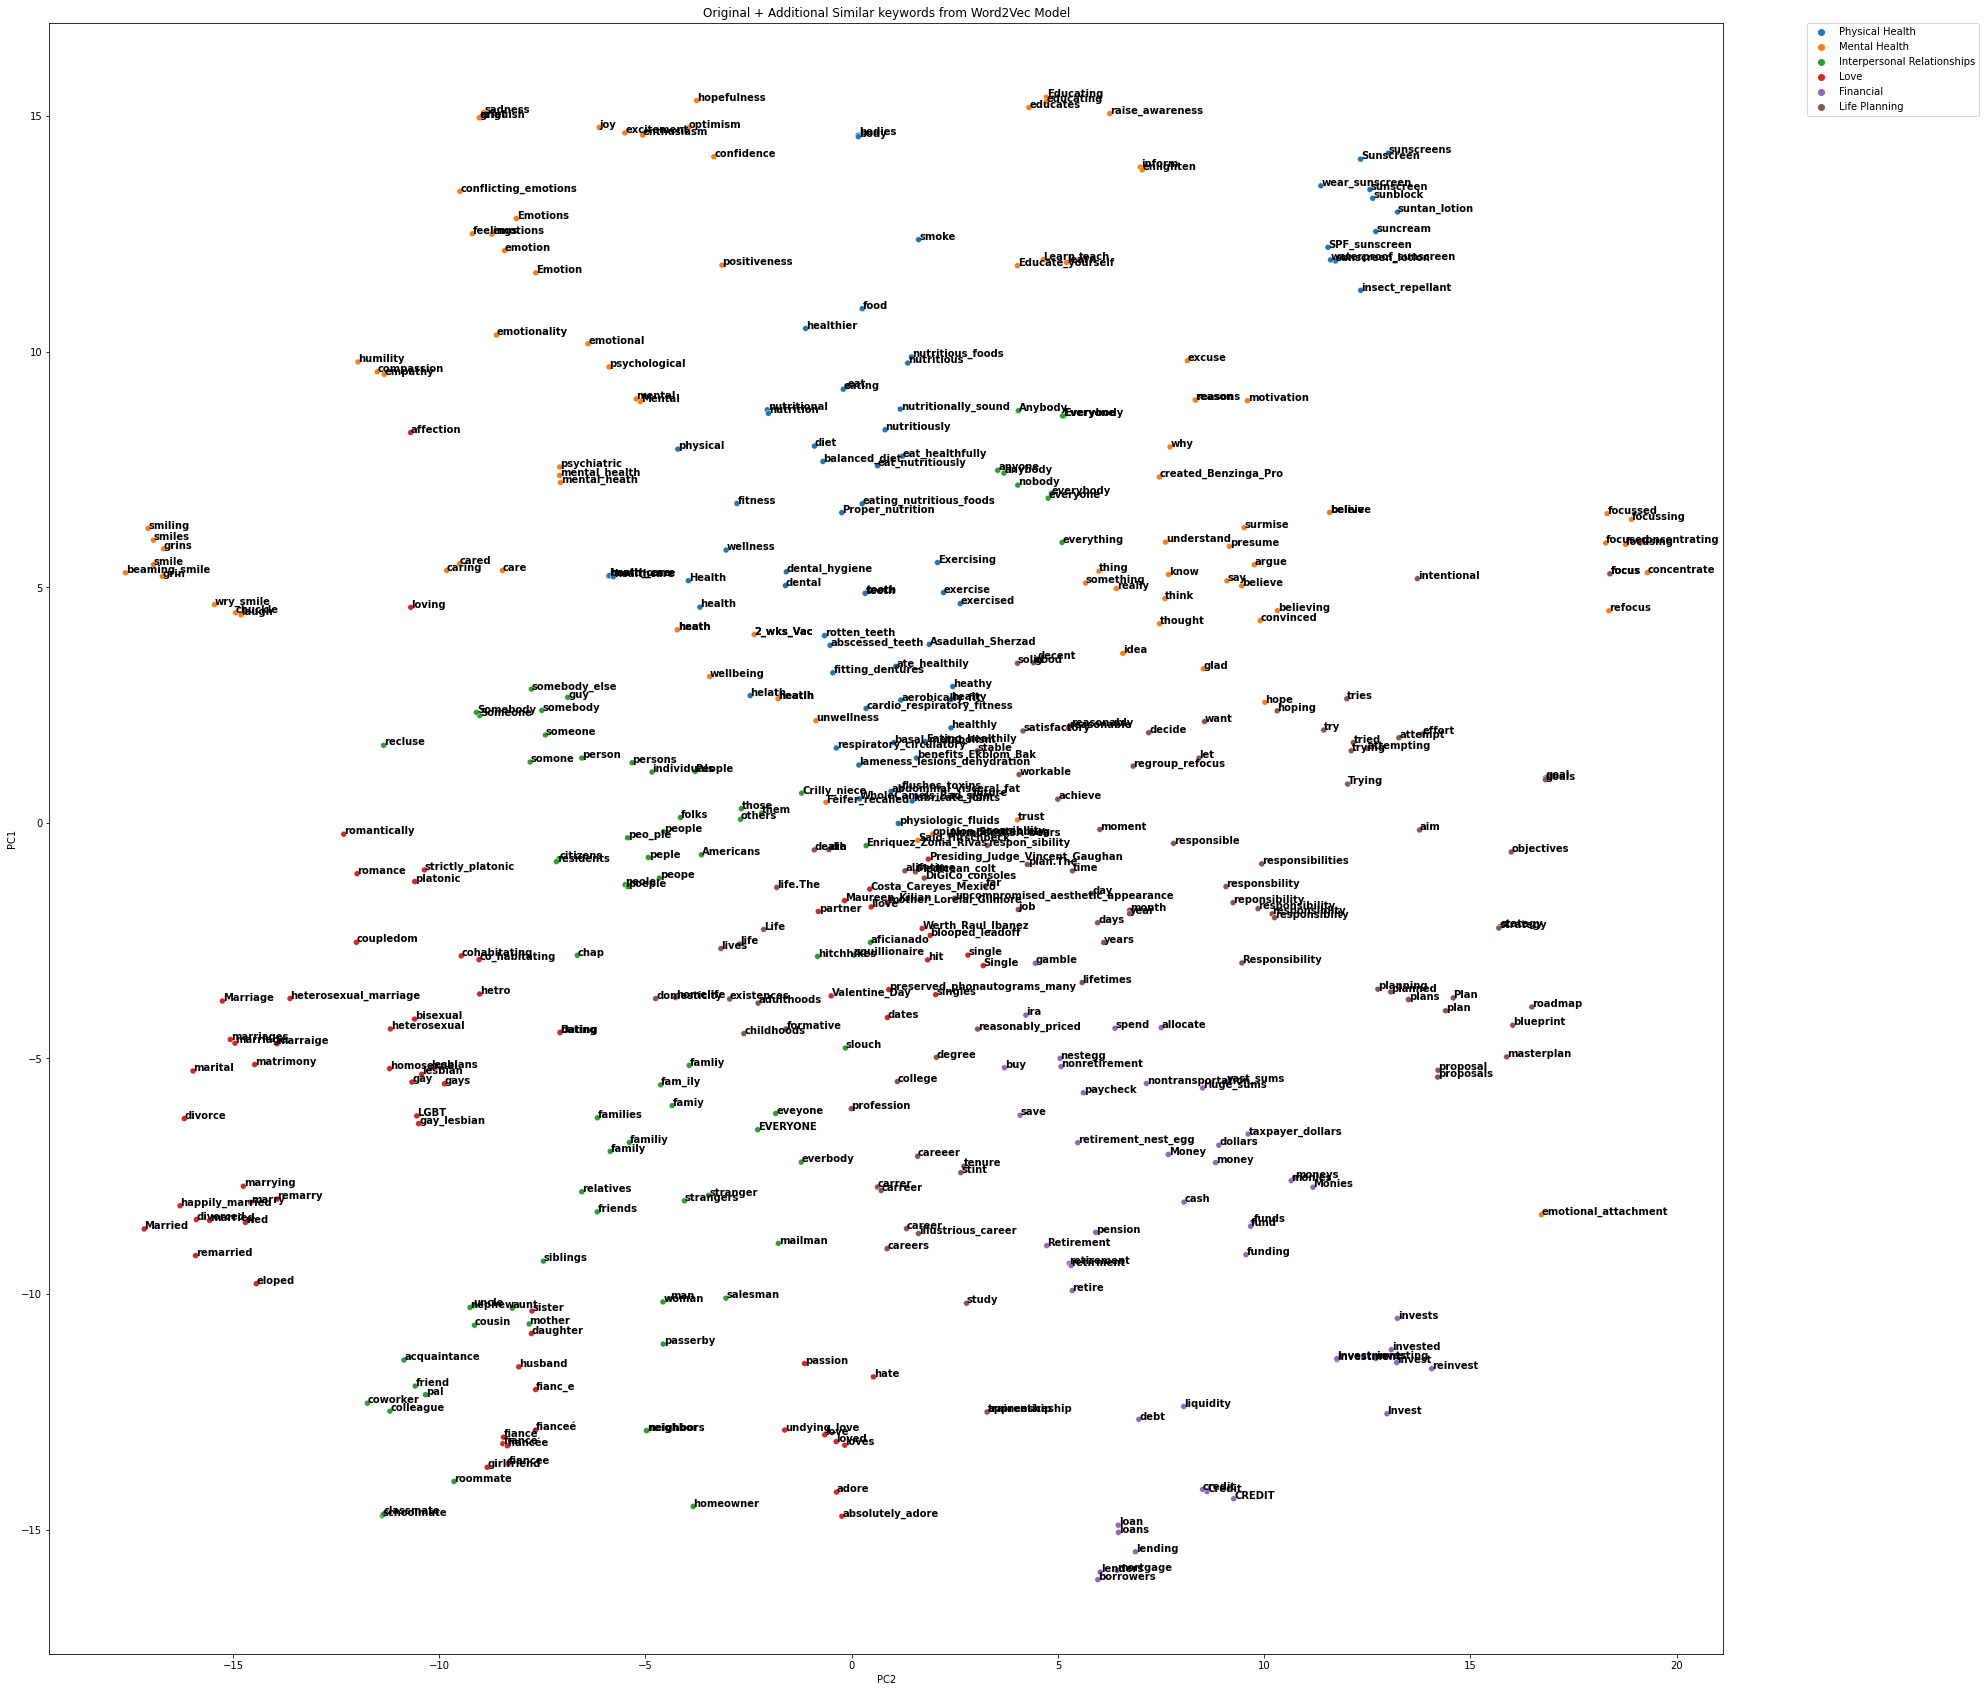

In [38]:
# Graph all keywords and similarities (colored by topic) to view closeness between topics
x = [val[0] for val in squished_vals_enhanced]
y = [val[1] for val in squished_vals_enhanced]
labels = enhanced_words_df['Word']
col_cat = enhanced_words_df['Topic']

plt.rcParams["figure.figsize"] = (30,30)
plt1 = sns.scatterplot(x, y, hue=col_cat)
for i in range(len(labels)):
    plt1.text(x[i]+0.01, y[i], labels[i], horizontalalignment="left", size="medium", color="black", weight="semibold")

plt.title("Original + Additional Similar keywords from Word2Vec Model")
plt.xlabel("PC2")
plt.ylabel("PC1") 
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt1

In [ ]:
# Time to pickle!
# Save both the original and enhanced words and vector dataframes

# og_words_df
#with open('og_words_df.pkl', 'wb') as f:
#    pickle.dump(og_words_df, f)
# Read it back in
with open('og_words_df.pkl', 'rb') as f:
    og_words_df = pickle.load(f)
    
#  enhanced_words_df
#with open('enhanced_words_df.pkl', 'wb') as f:
#    pickle.dump(enhanced_words_df, f)
# Read it back in
with open('enhanced_words_df.pkl', 'rb') as f:
    enhanced_words_df = pickle.load(f)

In [43]:
# Iterate through the cleaned comments, to find word vectors. Compute their cosine similarity with each of the keywords to 
# determine topic.

topic_assignment = []
for comment in cleaned_text:
    topic_scores = {}  # Build dict to hold topic and score for comment
    for topic in topic_list:  # topic_list contains all the topic names
        topic_scores[topic] = 0
    for word in comment:
        if word in w2v_model.key_to_index:
            vec = w2v_model[word]  # Get vector values
            for index, keyword_vec in enumerate(words):  # Using 'words' list generated for enhanced_words_df
                cos_sim = w2v_model.similarity(word, keyword_vec)
                # Keep a running sum for each topic
                topic_scores[topics[index]] += cos_sim  # Using 'topics' list generated for enhanced_words_df
    # Choose the topic with the highest similarity score from topic_scores
    # Divide the score by the number of keywords in the topic, if a topic has more keywords it will have a higher score due to volume
    for key in topic_scores.keys(): 
        if topic_scores[key] != 0:  # Get the list len of the enhanced_words_df where 
            word_count = len(enhanced_keyword_dict[key]["words"])
            topic_scores[key] = topic_scores[key]/word_count
    topic_max = [key for key, value in topic_scores.items() if value == max(topic_scores.values())]
    topic_assignment.append(max(topic_scores, key=topic_scores.get)) 

In [11]:
# Time to pickle!
# Save the topic assignments list
#with open('topic_assignment.pkl', 'wb') as f:
#    pickle.dump(topic_assignment, f)
    
# Read it back in
with open('topic_assignment.pkl', 'rb') as f:
    topic_assignment = pickle.load(f)

len(topic_assignment)

1278

<AxesSubplot:ylabel='count'>

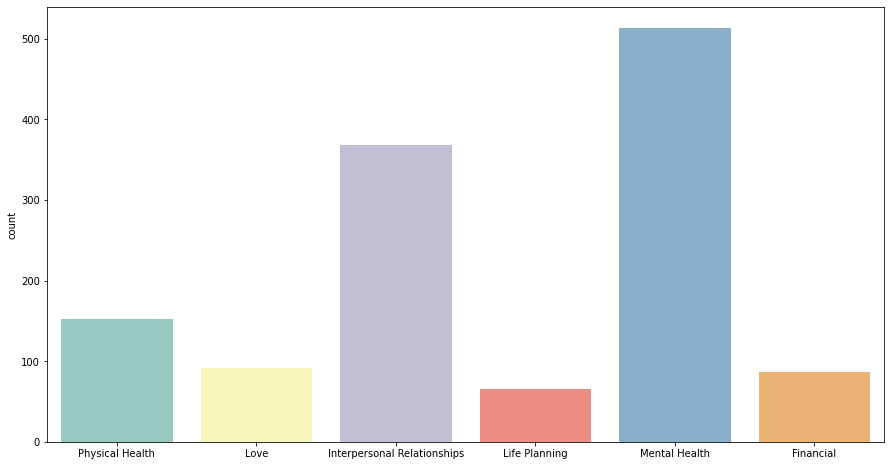

In [44]:
# Plot topic counts
plt.rcParams["figure.figsize"] = (15,8)
sns.countplot(topic_assignment, palette="Set3")

In [12]:
# Look at some examples to determine if the label is the best one.
ex_indices = [index for index,val in enumerate(topic_assignment) if val == "Life Planning"]

rand_indices = random.sample(ex_indices, k=10)
for ind in rand_indices:
    print(cleaned_text[ind])

['live', 'best', 'life', '1', 'make', 'best']
['plan', 'want', 'achieve', 'spend', 'sometime', 'everyday', 'working', 'towards', 'find', 'others', 'goal', 'encourage', 'enjoy', 'achieve']
['take', 'responsibility', 'action']
['plan']
['goal', 'life', 'let', 'stand', 'way']
['failure', 'isnt', 'opposite', 'success', 'path']
['minimum', 'least', 'honest']
['start', '401k', 'asap']
['slow']
['excellent']


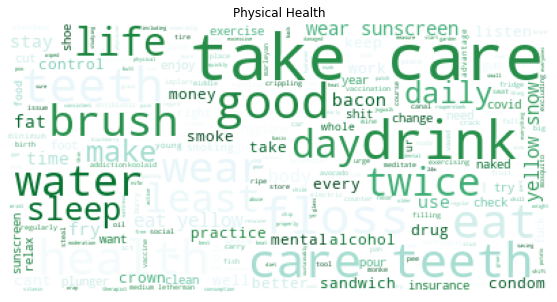

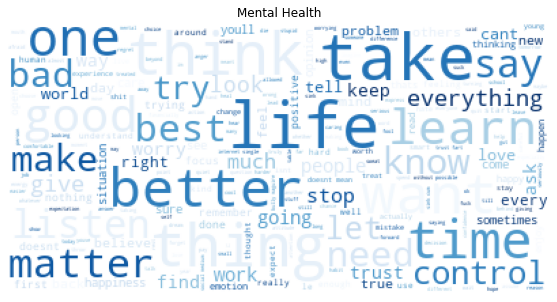

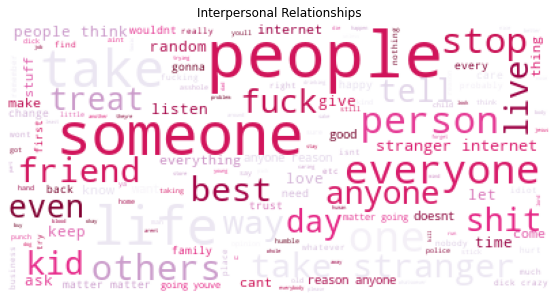

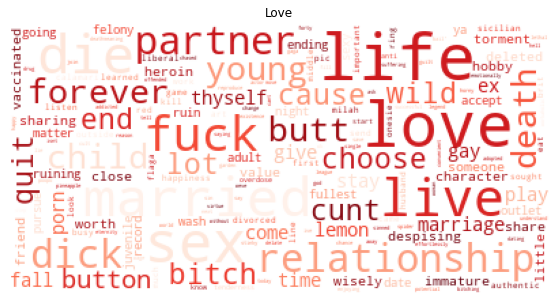

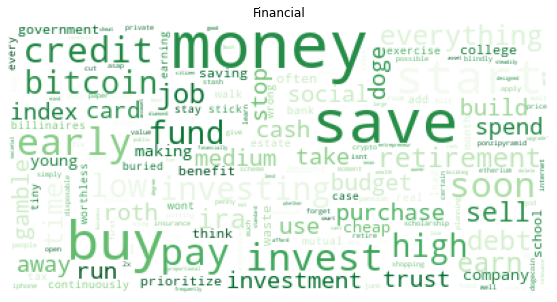

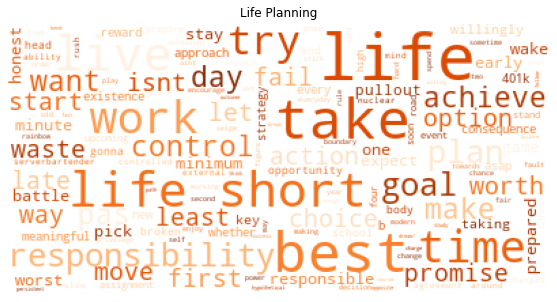

In [49]:
# Create wordcloud for each topic
plt.rcParams["figure.figsize"] = (14,5)
colors = ["BuGn", "Blues", "PuRd", "Reds", "Greens", "Oranges"]

for index, topic in enumerate(topic_list[:-1]):
    topic_indices = [index for index, val in enumerate(topic_assignment) if val == topic]
    text = [' '.join(val) for index, val in enumerate(cleaned_text) if index in topic_indices]
    text_str = str([' '.join(str(comment) for comment in text)])
    text_str = text_str.replace("[", "")
    text_str = text_str.replace("]", "")
    color = colors[index]
            
    wc = WordCloud(background_color='white', max_words=2000, stopwords=None, max_font_size=48, random_state=42,
                  colormap=color)
    wc.generate(text_str)
    
    plt.imshow(wc)
    plt.title(topic)
    plt.axis('off')
    plt.show()

# Additional Exploration

Explored a few other techniques: GSDMM, Univeral Sentence Encoder (USE), and Zero Shot Classification.

## GSDMM: Short Text Clustering

Link to repo: https://github.com/rwalk/gsdmm

Information from ReadMe:

This project implements the Gibbs sampling algorithm for a Dirichlet Mixture Model of Yin and Wang 2014 for the clustering of short text documents. Some advantages of this algorithm:
 - It requires only an upper bound K on the number of clusters
 - With good parameter selection, the model converges quickly
 - Space efficient and scalable
 
Link for example: https://stackoverflow.com/questions/62108771/a-practical-example-of-gsdmm-in-python

In [57]:
from gsdmm.gsdmm import MovieGroupProcess
mgp = MovieGroupProcess(K=6, alpha=0.1, beta=0.1, n_iters=30)  # Trying with 6 clusters

In [58]:
vocab_size = len(set(x for doc in cleaned_text for x in doc))
mgp_model = mgp.fit(cleaned_text, vocab_size)

In stage 0: transferred 913 clusters with 6 clusters populated
In stage 1: transferred 568 clusters with 6 clusters populated
In stage 2: transferred 504 clusters with 6 clusters populated
In stage 3: transferred 412 clusters with 6 clusters populated
In stage 4: transferred 406 clusters with 6 clusters populated
In stage 5: transferred 394 clusters with 6 clusters populated
In stage 6: transferred 391 clusters with 6 clusters populated
In stage 7: transferred 368 clusters with 6 clusters populated
In stage 8: transferred 353 clusters with 6 clusters populated
In stage 9: transferred 341 clusters with 6 clusters populated
In stage 10: transferred 352 clusters with 6 clusters populated
In stage 11: transferred 313 clusters with 6 clusters populated
In stage 12: transferred 335 clusters with 6 clusters populated
In stage 13: transferred 338 clusters with 6 clusters populated
In stage 14: transferred 312 clusters with 6 clusters populated
In stage 15: transferred 320 clusters with 6 clust

In [59]:
def top_words(cluster_word_distribution, top_cluster, values):
    for cluster in top_cluster:
        sort_dicts = sorted(
            mgp.cluster_word_distribution[cluster].items(),
            key=lambda k: k[1],
            reverse=True,
        )[:values]
        print('Cluster %s : %s'%(cluster,sort_dicts))
        print(' — — — — — — — — — ')

doc_count = np.array(mgp.cluster_doc_count)
top_index = doc_count.argsort()[-10:][::-1]
top_words(mgp.cluster_word_distribution, top_index, 10)

Cluster 4 : [('people', 43), ('think', 32), ('life', 23), ('listen', 23), ('like', 21), ('stop', 21), ('others', 18), ('know', 17), ('way', 17), ('someone', 16)]
 — — — — — — — — — 
Cluster 0 : [('life', 52), ('time', 20), ('thing', 20), ('live', 18), ('want', 17), ('better', 17), ('one', 16), ('try', 15), ('find', 15), ('best', 14)]
 — — — — — — — — — 
Cluster 5 : [('take', 29), ('ever', 23), ('control', 21), ('reason', 21), ('matter', 21), ('someone', 17), ('anyone', 16), ('love', 16), ('going', 15), ('thing', 14)]
 — — — — — — — — — 
Cluster 2 : [('take', 55), ('stranger', 22), ('care', 20), ('internet', 20), ('trust', 19), ('teeth', 14), ('one', 14), ('die', 11), ('people', 10), ('listen', 10)]
 — — — — — — — — — 
Cluster 1 : [('money', 20), ('start', 18), ('save', 18), ('take', 13), ('learn', 11), ('buy', 11), ('life', 9), ('early', 9), ('stay', 9), ('time', 8)]
 — — — — — — — — — 
Cluster 3 : [('look', 14), ('back', 8), ('shall', 6), ('better', 6), ('sink', 6), ('kind', 6), ('buy

## Universal Sentence Encoder (USE)

USE embeds sentences without any required pre-processing steps. Played around with USE since I will use it for my next project.

In [65]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embeddings = embed([
    "The quick brown fox jumps over the lazy dog.",
    "I am a sentence for which I would like to get its embedding"])

print(embeddings)

tf.Tensor(
[[-0.03133016 -0.06338632 -0.01607501 ... -0.03242781 -0.04575741
   0.05370456]
 [ 0.05080862 -0.01652432  0.01573779 ...  0.00976659  0.0317012
   0.01788118]], shape=(2, 512), dtype=float32)


In [66]:
txt_embeddings = embed(comment_raw_list)
txt_embeddings.shape

TensorShape([1298, 512])

In [67]:
# Create df with similarities
#num_comments = len(comment_raw_list)
#num_comments = 10
example_comment_indices = [11,13,14,17,21,28,43,42,45,116]
embed_df = pd.DataFrame()
for ind in example_comment_indices:
    for other_ind in example_comment_indices:
        # cosine calc: cos(theta) = x * y / (mag_x * mag_y)
        dot_prod = np.dot(txt_embeddings[ind], txt_embeddings[other_ind])
        mag_x = np.sqrt(np.dot(txt_embeddings[ind], txt_embeddings[ind]))
        mag_y = np.sqrt(np.dot(txt_embeddings[other_ind], txt_embeddings[other_ind]))
        cos_theta = dot_prod/(mag_x * mag_y)
        
        embed_df = embed_df.append(
        {
            'similarity': cos_theta,
            'comment 1': comment_raw_list[ind],
            'comment 2': comment_raw_list[other_ind]
        }, ignore_index=True)

In [ ]:
# Visualize - 10 examples only
plt.rcParams["figure.figsize"] = (20,20)
sim_heatmap = embed_df.pivot('comment 1', 'comment 2', 'similarity')
ax = sns.heatmap(sim_heatmap, cmap='YlGnBu')
plt.show()

In [ ]:
# Find some good examples to valdiate similarity values
# Find some similar sentences and some non-similar sentences - preferably shorter text.
for i,v in enumerate(comment_raw_list[100:120]):
    num = i + 100
    print(f"{num}: {v}\n")

In [ ]:
# Use k-means clustering to cluster the sentences based on the USE vector values
#https://www.kaggle.com/code/nicapotato/universal-sentence-encoder-clustering-poc/notebook
from sklearn.cluster import KMeans

kmeans_df = pd.DataFrame()
kmeans_df['comment'] = comment_raw_list
kmeans_df['use_embed'] = txt_embeddings

kmeans = KMeans(n_clusters=5).fit(txt_embeddings)
#embed_df.loc[:,'Clusters'] = None
kmeans_df.loc[:,'cluster'] = kmeans.labels_
kmeans_df.head()

In [ ]:
# Time to pickle!
#with open('kmeans_df.pkl', 'wb') as f:
#    pickle.dump(kmeans_df, f)

# Read it back in
with open('kmeans_df.pkl', 'rb') as f:
    kmeans_df1 = pickle.load(f)

kmeans_df1.head()

## Automatic Labeling via Zero Shot Classification

Zero Shot Classification from HuggingFace will assign given labels to examples with no prior learning/training.
https://medium.com/algoanalytics/automatic-labelling-of-text-for-nlp-5270e70a2f5f

Not impressed with results, will not continue with Zero shot classification but may try it on a different dataset.

In [68]:
from transformers import pipeline

# Output labels
comment_labels = ["Physical Health", "Mental Health", "Interpersonal Relationships", "Love Life", "Financial",
                    "Life Planning", "Other"]

# device=0 for GPU usage
classifier = pipeline("zero-shot-classification")  # Uses default model, roberta
                      #,model="facebook/bart-large-mnli", device=0)

# Grab sample text
example_comment_indices = [11,13,14,17,21,28,43,42,45,116]


# Sample code to see labels 
for i in range(0, 500):

    input_text = comment_raw_list[i].split(sep='.')[0]  # Grab first sentence only
  
  # multi_label=True will return confidence score for both labels independently 
    model_dict = classifier(input_text, comment_labels, multi_label=True)

  # Zip results to dict
    #result_dict = dict(zip(model_dict.get('labels'), model_dict.get('scores')))
  
  # Print confidence scores
    print("Input Text for the model : ", input_text)
    #print(" Model : ", model_dict)
    print("Confidence Score for Physical Health Class : ", model_dict.get('scores')[0])
    print("Confidence Score for Mental Health Class : ", model_dict.get('scores')[1])
    print("Confidence Score for Personal Relationships Class : ", model_dict.get('scores')[2])
    print("Confidence Score for Love Life Class : ", model_dict.get('scores')[3])
    print("Confidence Score for Financial Class : ", model_dict.get('scores')[4])
    print("Confidence Score for Life Planning Class : ", model_dict.get('scores')[5])
    print("Confidence Score for Other Class : ", model_dict.get('scores')[6], '\n\n')

No model was supplied, defaulted to roberta-large-mnli (https://huggingface.co/roberta-large-mnli)
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at roberta-large-mnli.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


Input Text for the model :  Take care of your teeth and body when you are young
Confidence Score for Physical Health Class :  0.9801022410392761
Confidence Score for Mental Health Class :  0.9092966914176941
Confidence Score for Personal Relationships Class :  0.1102067306637764
Confidence Score for Love Life Class :  0.06351105123758316
Confidence Score for Financial Class :  0.06008955091238022
Confidence Score for Life Planning Class :  0.0459570474922657
Confidence Score for Other Class :  0.02916276641190052 


Input Text for the model :  You are only young once, but you can be immature forever
Confidence Score for Physical Health Class :  0.29360583424568176
Confidence Score for Mental Health Class :  0.10904479026794434
Confidence Score for Personal Relationships Class :  0.08409426361322403
Confidence Score for Love Life Class :  0.0781412124633789
Confidence Score for Financial Class :  0.07593066245317459
Confidence Score for Life Planning Class :  0.04826727509498596
Confide

Input Text for the model :  do what you have to do so you can do what you want to do
Confidence Score for Physical Health Class :  0.33446481823921204
Confidence Score for Mental Health Class :  0.31741201877593994
Confidence Score for Personal Relationships Class :  0.2447417974472046
Confidence Score for Love Life Class :  0.23380576074123383
Confidence Score for Financial Class :  0.15914933383464813
Confidence Score for Life Planning Class :  0.1109585240483284
Confidence Score for Other Class :  0.09412219375371933 


Input Text for the model :  Try it
Confidence Score for Physical Health Class :  0.35962721705436707
Confidence Score for Mental Health Class :  0.3128524124622345
Confidence Score for Personal Relationships Class :  0.29325613379478455
Confidence Score for Love Life Class :  0.2774334251880646
Confidence Score for Financial Class :  0.26538822054862976
Confidence Score for Life Planning Class :  0.251151442527771
Confidence Score for Other Class :  0.240525543689727

Input Text for the model :  Don't be 100% sure you're right at anything
Confidence Score for Physical Health Class :  0.16806042194366455
Confidence Score for Mental Health Class :  0.1311529129743576
Confidence Score for Personal Relationships Class :  0.13007019460201263
Confidence Score for Love Life Class :  0.12526896595954895
Confidence Score for Financial Class :  0.09207592159509659
Confidence Score for Life Planning Class :  0.08840091526508331
Confidence Score for Other Class :  0.05545305833220482 


Input Text for the model :  Beyond money, beyond time, the most valuable thing you can have is your human connections
Confidence Score for Physical Health Class :  0.9847578406333923
Confidence Score for Mental Health Class :  0.2602406442165375
Confidence Score for Personal Relationships Class :  0.21702156960964203
Confidence Score for Love Life Class :  0.18229705095291138
Confidence Score for Financial Class :  0.0610547736287117
Confidence Score for Life Planning Class :  0

Input Text for the model :  treat everyone the way you want to be treated
Confidence Score for Physical Health Class :  0.5473536849021912
Confidence Score for Mental Health Class :  0.3075004518032074
Confidence Score for Personal Relationships Class :  0.26294034719467163
Confidence Score for Love Life Class :  0.139703169465065
Confidence Score for Financial Class :  0.10346858203411102
Confidence Score for Life Planning Class :  0.0848216712474823
Confidence Score for Other Class :  0.07428377121686935 


Input Text for the model :  Always prioritize her comfort over your pleasure
Confidence Score for Physical Health Class :  0.7988170981407166
Confidence Score for Mental Health Class :  0.7670001983642578
Confidence Score for Personal Relationships Class :  0.4603038430213928
Confidence Score for Love Life Class :  0.4025064706802368
Confidence Score for Financial Class :  0.2916225790977478
Confidence Score for Life Planning Class :  0.2500282824039459
Confidence Score for Other 

Input Text for the model :  Be kind to yourself! We are often our worst enemies
Confidence Score for Physical Health Class :  0.6936595439910889
Confidence Score for Mental Health Class :  0.44735822081565857
Confidence Score for Personal Relationships Class :  0.3792274296283722
Confidence Score for Love Life Class :  0.18547610938549042
Confidence Score for Financial Class :  0.15343201160430908
Confidence Score for Life Planning Class :  0.09910188615322113
Confidence Score for Other Class :  0.09027678519487381 


Input Text for the model :  [deleted]
Confidence Score for Physical Health Class :  0.3610967993736267
Confidence Score for Mental Health Class :  0.2919882833957672
Confidence Score for Personal Relationships Class :  0.2571600079536438
Confidence Score for Love Life Class :  0.14392754435539246
Confidence Score for Financial Class :  0.10887614637613297
Confidence Score for Life Planning Class :  0.10091143846511841
Confidence Score for Other Class :  0.0817563459277153

Input Text for the model :  Don’t panic…
Confidence Score for Physical Health Class :  0.7992627620697021
Confidence Score for Mental Health Class :  0.7116272449493408
Confidence Score for Personal Relationships Class :  0.5679452419281006
Confidence Score for Love Life Class :  0.4721508026123047
Confidence Score for Financial Class :  0.46821120381355286
Confidence Score for Life Planning Class :  0.34904390573501587
Confidence Score for Other Class :  0.21890106797218323 


Input Text for the model :  Live
Confidence Score for Physical Health Class :  0.6857209801673889
Confidence Score for Mental Health Class :  0.649647057056427
Confidence Score for Personal Relationships Class :  0.371177077293396
Confidence Score for Love Life Class :  0.3258747160434723
Confidence Score for Financial Class :  0.10975687205791473
Confidence Score for Life Planning Class :  0.09421469271183014
Confidence Score for Other Class :  0.0183773972094059 


Input Text for the model :  wear sunscreen
Co

Input Text for the model :  Quit being a little bitch and get vaccinated
Confidence Score for Physical Health Class :  0.600337028503418
Confidence Score for Mental Health Class :  0.2517296373844147
Confidence Score for Personal Relationships Class :  0.19208784401416779
Confidence Score for Love Life Class :  0.16912680864334106
Confidence Score for Financial Class :  0.1610090136528015
Confidence Score for Life Planning Class :  0.024163082242012024
Confidence Score for Other Class :  0.019904974848031998 


Input Text for the model :  Don’t have kids young, 30+
Confidence Score for Physical Health Class :  0.8911530375480652
Confidence Score for Mental Health Class :  0.35479408502578735
Confidence Score for Personal Relationships Class :  0.09967499226331711
Confidence Score for Love Life Class :  0.08617903292179108
Confidence Score for Financial Class :  0.08284676820039749
Confidence Score for Life Planning Class :  0.04436080530285835
Confidence Score for Other Class :  0.0323

Input Text for the model :  Don’t get in a relationship with someone who cannot take care of themselves
Confidence Score for Physical Health Class :  0.7099562883377075
Confidence Score for Mental Health Class :  0.5682613849639893
Confidence Score for Personal Relationships Class :  0.41676852107048035
Confidence Score for Love Life Class :  0.4013859033584595
Confidence Score for Financial Class :  0.186253160238266
Confidence Score for Life Planning Class :  0.09656213223934174
Confidence Score for Other Class :  0.07463005930185318 


Input Text for the model :  Learn to say "NO" to yourself and STAY out of debt
Confidence Score for Physical Health Class :  0.9384248852729797
Confidence Score for Mental Health Class :  0.844073474407196
Confidence Score for Personal Relationships Class :  0.5192314386367798
Confidence Score for Love Life Class :  0.39144831895828247
Confidence Score for Financial Class :  0.23873277008533478
Confidence Score for Life Planning Class :  0.19713421165

Input Text for the model :  Don’t die
Confidence Score for Physical Health Class :  0.930826723575592
Confidence Score for Mental Health Class :  0.3151991069316864
Confidence Score for Personal Relationships Class :  0.19418640434741974
Confidence Score for Love Life Class :  0.12195806205272675
Confidence Score for Financial Class :  0.10819622874259949
Confidence Score for Life Planning Class :  0.07388804852962494
Confidence Score for Other Class :  0.018952328711748123 


Input Text for the model :  Save money
Confidence Score for Physical Health Class :  0.9801647663116455
Confidence Score for Mental Health Class :  0.15738263726234436
Confidence Score for Personal Relationships Class :  0.09027991443872452
Confidence Score for Love Life Class :  0.06770250201225281
Confidence Score for Financial Class :  0.05791651830077171
Confidence Score for Life Planning Class :  0.016169294714927673
Confidence Score for Other Class :  0.015511630102992058 


Input Text for the model :  Thin

Input Text for the model :  Have more naps
Confidence Score for Physical Health Class :  0.9033657908439636
Confidence Score for Mental Health Class :  0.8203861117362976
Confidence Score for Personal Relationships Class :  0.6438040733337402
Confidence Score for Love Life Class :  0.16400665044784546
Confidence Score for Financial Class :  0.1486593633890152
Confidence Score for Life Planning Class :  0.08514809608459473
Confidence Score for Other Class :  0.025149933993816376 


Input Text for the model :  If you make your hobby your work, you never have to work again
Confidence Score for Physical Health Class :  0.2260855883359909
Confidence Score for Mental Health Class :  0.22341690957546234
Confidence Score for Personal Relationships Class :  0.2077006995677948
Confidence Score for Love Life Class :  0.19088146090507507
Confidence Score for Financial Class :  0.1624925583600998
Confidence Score for Life Planning Class :  0.1370668262243271
Confidence Score for Other Class :  0.11

Input Text for the model :  You have exactly the same right to occupy your space as the next guy
Confidence Score for Physical Health Class :  0.4855966567993164
Confidence Score for Mental Health Class :  0.34101206064224243
Confidence Score for Personal Relationships Class :  0.1991727203130722
Confidence Score for Love Life Class :  0.14858870208263397
Confidence Score for Financial Class :  0.12337640672922134
Confidence Score for Life Planning Class :  0.09156058728694916
Confidence Score for Other Class :  0.06567925959825516 


Input Text for the model :  Invest atleast 1000$ every month when you are in 20’s and that really adds up into something great to let you do in your 30s
Confidence Score for Physical Health Class :  0.8465778231620789
Confidence Score for Mental Health Class :  0.5373145341873169
Confidence Score for Personal Relationships Class :  0.2926987111568451
Confidence Score for Love Life Class :  0.22940585017204285
Confidence Score for Financial Class :  0.1567

Input Text for the model :  Get a covid vaccination
Confidence Score for Physical Health Class :  0.6861081123352051
Confidence Score for Mental Health Class :  0.15891008079051971
Confidence Score for Personal Relationships Class :  0.07084374129772186
Confidence Score for Love Life Class :  0.03365049511194229
Confidence Score for Financial Class :  0.028404802083969116
Confidence Score for Life Planning Class :  0.025237802416086197
Confidence Score for Other Class :  0.00844326987862587 


Input Text for the model :  Buy real estate
Confidence Score for Physical Health Class :  0.2774627208709717
Confidence Score for Mental Health Class :  0.2505187392234802
Confidence Score for Personal Relationships Class :  0.055548906326293945
Confidence Score for Love Life Class :  0.008161013014614582
Confidence Score for Financial Class :  0.006435184273868799
Confidence Score for Life Planning Class :  0.0036067282781004906
Confidence Score for Other Class :  0.0017830304568633437 


Input 

Input Text for the model :  Look inward when in doubt
Confidence Score for Physical Health Class :  0.37549498677253723
Confidence Score for Mental Health Class :  0.2728574275970459
Confidence Score for Personal Relationships Class :  0.21446716785430908
Confidence Score for Love Life Class :  0.18882261216640472
Confidence Score for Financial Class :  0.16945406794548035
Confidence Score for Life Planning Class :  0.08278560638427734
Confidence Score for Other Class :  0.07912888377904892 


Input Text for the model :  Always work on your pull-out game!
Confidence Score for Physical Health Class :  0.1768878549337387
Confidence Score for Mental Health Class :  0.14936263859272003
Confidence Score for Personal Relationships Class :  0.13947953283786774
Confidence Score for Love Life Class :  0.08300895243883133
Confidence Score for Financial Class :  0.05697254091501236
Confidence Score for Life Planning Class :  0.04121642932295799
Confidence Score for Other Class :  0.01655554026365

Input Text for the model :  "Be smart about being stupid
Confidence Score for Physical Health Class :  0.18366828560829163
Confidence Score for Mental Health Class :  0.1730208396911621
Confidence Score for Personal Relationships Class :  0.12344246357679367
Confidence Score for Love Life Class :  0.1207599863409996
Confidence Score for Financial Class :  0.07875403016805649
Confidence Score for Life Planning Class :  0.041201625019311905
Confidence Score for Other Class :  0.03076750598847866 


Input Text for the model :  Willingly taking on responsibility is the key to a meaningful existence
Confidence Score for Physical Health Class :  0.3487403392791748
Confidence Score for Mental Health Class :  0.32720816135406494
Confidence Score for Personal Relationships Class :  0.2797831892967224
Confidence Score for Love Life Class :  0.23426347970962524
Confidence Score for Financial Class :  0.18023967742919922
Confidence Score for Life Planning Class :  0.1443355828523636
Confidence Sco

Input Text for the model :  Start that 401k ASAP
Confidence Score for Physical Health Class :  0.9761972427368164
Confidence Score for Mental Health Class :  0.7854906916618347
Confidence Score for Personal Relationships Class :  0.13460087776184082
Confidence Score for Love Life Class :  0.04296720027923584
Confidence Score for Financial Class :  0.03417149931192398
Confidence Score for Life Planning Class :  0.02703370526432991
Confidence Score for Other Class :  0.016546867787837982 


Input Text for the model :  Use sunscreen!
Confidence Score for Physical Health Class :  0.9604701399803162
Confidence Score for Mental Health Class :  0.44610193371772766
Confidence Score for Personal Relationships Class :  0.14788343012332916
Confidence Score for Love Life Class :  0.14449496567249298
Confidence Score for Financial Class :  0.09908724576234818
Confidence Score for Life Planning Class :  0.03321542590856552
Confidence Score for Other Class :  0.02274782955646515 


Input Text for the

Input Text for the model :  “Don’t let them tell you about it, experience it
Confidence Score for Physical Health Class :  0.4051471948623657
Confidence Score for Mental Health Class :  0.38930678367614746
Confidence Score for Personal Relationships Class :  0.31661075353622437
Confidence Score for Love Life Class :  0.3014815151691437
Confidence Score for Financial Class :  0.29201096296310425
Confidence Score for Life Planning Class :  0.28777140378952026
Confidence Score for Other Class :  0.2677171528339386 


Input Text for the model :  no matter how bad your life may get, just know that it will go back to normal
Confidence Score for Physical Health Class :  0.9325251579284668
Confidence Score for Mental Health Class :  0.26932334899902344
Confidence Score for Personal Relationships Class :  0.1745949536561966
Confidence Score for Love Life Class :  0.14558258652687073
Confidence Score for Financial Class :  0.1117963045835495
Confidence Score for Life Planning Class :  0.10884591

Input Text for the model :  Don’t put your dick in crazy
Confidence Score for Physical Health Class :  0.3791384994983673
Confidence Score for Mental Health Class :  0.3503498136997223
Confidence Score for Personal Relationships Class :  0.32008200883865356
Confidence Score for Love Life Class :  0.3195266127586365
Confidence Score for Financial Class :  0.26916778087615967
Confidence Score for Life Planning Class :  0.23907437920570374
Confidence Score for Other Class :  0.1147644966840744 


Input Text for the model :  No matter how sexy that outlet is, don’t fuck it
Confidence Score for Physical Health Class :  0.325133740901947
Confidence Score for Mental Health Class :  0.22832687199115753
Confidence Score for Personal Relationships Class :  0.1853344589471817
Confidence Score for Love Life Class :  0.1093931719660759
Confidence Score for Financial Class :  0.1079649031162262
Confidence Score for Life Planning Class :  0.07479697465896606
Confidence Score for Other Class :  0.0432

Input Text for the model :  the world doesn’t cater to your triggers
Confidence Score for Physical Health Class :  0.7444174289703369
Confidence Score for Mental Health Class :  0.16944053769111633
Confidence Score for Personal Relationships Class :  0.15471938252449036
Confidence Score for Love Life Class :  0.15315775573253632
Confidence Score for Financial Class :  0.12360918521881104
Confidence Score for Life Planning Class :  0.06413109600543976
Confidence Score for Other Class :  0.059913963079452515 


Input Text for the model :  Every human is bad, even you
Confidence Score for Physical Health Class :  0.271014541387558
Confidence Score for Mental Health Class :  0.1446954309940338
Confidence Score for Personal Relationships Class :  0.0956314280629158
Confidence Score for Love Life Class :  0.0632285326719284
Confidence Score for Financial Class :  0.0560220405459404
Confidence Score for Life Planning Class :  0.04765789955854416
Confidence Score for Other Class :  0.036482047

Input Text for the model :  Try new things
Confidence Score for Physical Health Class :  0.3378741145133972
Confidence Score for Mental Health Class :  0.3341367840766907
Confidence Score for Personal Relationships Class :  0.32986271381378174
Confidence Score for Love Life Class :  0.27985242009162903
Confidence Score for Financial Class :  0.25956055521965027
Confidence Score for Life Planning Class :  0.23706817626953125
Confidence Score for Other Class :  0.20400169491767883 


Input Text for the model :  No Cuts, No Butts, No Coconuts
Confidence Score for Physical Health Class :  0.895969033241272
Confidence Score for Mental Health Class :  0.879252552986145
Confidence Score for Personal Relationships Class :  0.49220454692840576
Confidence Score for Love Life Class :  0.45885464549064636
Confidence Score for Financial Class :  0.3117430508136749
Confidence Score for Life Planning Class :  0.2954513430595398
Confidence Score for Other Class :  0.13464227318763733 


Input Text for

Input Text for the model :  Don't take advice from random people on the internet
Confidence Score for Physical Health Class :  0.3733670711517334
Confidence Score for Mental Health Class :  0.2831825613975525
Confidence Score for Personal Relationships Class :  0.2734204828739166
Confidence Score for Love Life Class :  0.2697274386882782
Confidence Score for Financial Class :  0.2642577886581421
Confidence Score for Life Planning Class :  0.19683445990085602
Confidence Score for Other Class :  0.08887170255184174 


Input Text for the model :  Make sure you wiped it clean properly
Confidence Score for Physical Health Class :  0.32956498861312866
Confidence Score for Mental Health Class :  0.3273155987262726
Confidence Score for Personal Relationships Class :  0.28353187441825867
Confidence Score for Love Life Class :  0.26482102274894714
Confidence Score for Financial Class :  0.23699234426021576
Confidence Score for Life Planning Class :  0.16785970330238342
Confidence Score for Other

Input Text for the model :  Don't argue with stupid
Confidence Score for Physical Health Class :  0.3614950478076935
Confidence Score for Mental Health Class :  0.30866119265556335
Confidence Score for Personal Relationships Class :  0.20045128464698792
Confidence Score for Love Life Class :  0.14702728390693665
Confidence Score for Financial Class :  0.14195239543914795
Confidence Score for Life Planning Class :  0.11225064843893051
Confidence Score for Other Class :  0.09380452334880829 


Input Text for the model :  Never entirely trust anything you hear
Confidence Score for Physical Health Class :  0.1483512669801712
Confidence Score for Mental Health Class :  0.14716395735740662
Confidence Score for Personal Relationships Class :  0.09986929595470428
Confidence Score for Love Life Class :  0.09447017312049866
Confidence Score for Financial Class :  0.09386036545038223
Confidence Score for Life Planning Class :  0.05839230865240097
Confidence Score for Other Class :  0.045845255255

Input Text for the model :  Stay in school
Confidence Score for Physical Health Class :  0.23906774818897247
Confidence Score for Mental Health Class :  0.18161866068840027
Confidence Score for Personal Relationships Class :  0.17091506719589233
Confidence Score for Love Life Class :  0.14262881875038147
Confidence Score for Financial Class :  0.11619463562965393
Confidence Score for Life Planning Class :  0.01572401635348797
Confidence Score for Other Class :  0.011827128008008003 


Input Text for the model :  Never take promises it's just gonna end in a broken promise
Confidence Score for Physical Health Class :  0.276088684797287
Confidence Score for Mental Health Class :  0.2466753125190735
Confidence Score for Personal Relationships Class :  0.1824295073747635
Confidence Score for Love Life Class :  0.15840300917625427
Confidence Score for Financial Class :  0.1507614701986313
Confidence Score for Life Planning Class :  0.1299550086259842
Confidence Score for Other Class :  0.057

Input Text for the model :  Life isn't fair, the sooner you realise this the happier you will be because you will stop expecting so much and you won't be surprised when something goes wrong
Confidence Score for Physical Health Class :  0.20447322726249695
Confidence Score for Mental Health Class :  0.17663562297821045
Confidence Score for Personal Relationships Class :  0.15895546972751617
Confidence Score for Love Life Class :  0.10273270308971405
Confidence Score for Financial Class :  0.08396388590335846
Confidence Score for Life Planning Class :  0.08123544603586197
Confidence Score for Other Class :  0.025363389402627945 


Input Text for the model :  It is okay to not have answers
Confidence Score for Physical Health Class :  0.27884525060653687
Confidence Score for Mental Health Class :  0.24344974756240845
Confidence Score for Personal Relationships Class :  0.18346717953681946
Confidence Score for Love Life Class :  0.1623172014951706
Confidence Score for Financial Class :  0.

Input Text for the model :  Look, you need to pick yourself up
Confidence Score for Physical Health Class :  0.8477334380149841
Confidence Score for Mental Health Class :  0.8331961631774902
Confidence Score for Personal Relationships Class :  0.46748071908950806
Confidence Score for Love Life Class :  0.22063283622264862
Confidence Score for Financial Class :  0.19910591840744019
Confidence Score for Life Planning Class :  0.17704333364963531
Confidence Score for Other Class :  0.048343513160943985 


Input Text for the model :  Button the middle button of a onesie first
Confidence Score for Physical Health Class :  0.2983086109161377
Confidence Score for Mental Health Class :  0.2950091063976288
Confidence Score for Personal Relationships Class :  0.2490568459033966
Confidence Score for Love Life Class :  0.08380138128995895
Confidence Score for Financial Class :  0.06907270103693008
Confidence Score for Life Planning Class :  0.06672985106706619
Confidence Score for Other Class :  0

Input Text for the model :  Save your pennies
Confidence Score for Physical Health Class :  0.9678872227668762
Confidence Score for Mental Health Class :  0.8796451091766357
Confidence Score for Personal Relationships Class :  0.2201937884092331
Confidence Score for Love Life Class :  0.16401401162147522
Confidence Score for Financial Class :  0.06571519374847412
Confidence Score for Life Planning Class :  0.0642387643456459
Confidence Score for Other Class :  0.04546753317117691 


Input Text for the model :  Don't give unsolicited advice
Confidence Score for Physical Health Class :  0.35711371898651123
Confidence Score for Mental Health Class :  0.3199516832828522
Confidence Score for Personal Relationships Class :  0.26867780089378357
Confidence Score for Love Life Class :  0.20772166550159454
Confidence Score for Financial Class :  0.2053610235452652
Confidence Score for Life Planning Class :  0.18980525434017181
Confidence Score for Other Class :  0.14301671087741852 


Input Text

Input Text for the model :  Live life to the fullest and do not try to mix up with other people's business or lives
Confidence Score for Physical Health Class :  0.8324710726737976
Confidence Score for Mental Health Class :  0.6786708235740662
Confidence Score for Personal Relationships Class :  0.44964611530303955
Confidence Score for Love Life Class :  0.4226260185241699
Confidence Score for Financial Class :  0.32780420780181885
Confidence Score for Life Planning Class :  0.20640644431114197
Confidence Score for Other Class :  0.17224080860614777 


Input Text for the model :  Don’t go to Reddit for advice
Confidence Score for Physical Health Class :  0.5467231869697571
Confidence Score for Mental Health Class :  0.36200371384620667
Confidence Score for Personal Relationships Class :  0.3411332964897156
Confidence Score for Love Life Class :  0.29291921854019165
Confidence Score for Financial Class :  0.28368040919303894
Confidence Score for Life Planning Class :  0.1963459104299545

Input Text for the model :  dont worry about it too much
Confidence Score for Physical Health Class :  0.6834812760353088
Confidence Score for Mental Health Class :  0.5628820061683655
Confidence Score for Personal Relationships Class :  0.446323961019516
Confidence Score for Love Life Class :  0.43839555978775024
Confidence Score for Financial Class :  0.2862633168697357
Confidence Score for Life Planning Class :  0.20727501809597015
Confidence Score for Other Class :  0.14690500497817993 


Input Text for the model :  Always tell the truth and keep your hands to yourself
Confidence Score for Physical Health Class :  0.7686302065849304
Confidence Score for Mental Health Class :  0.6367718577384949
Confidence Score for Personal Relationships Class :  0.4278471767902374
Confidence Score for Love Life Class :  0.344091534614563
Confidence Score for Financial Class :  0.3367052972316742
Confidence Score for Life Planning Class :  0.20666030049324036
Confidence Score for Other Class :  0.0

Input Text for the model :  give up on your dreams and die
Confidence Score for Physical Health Class :  0.37020501494407654
Confidence Score for Mental Health Class :  0.19542419910430908
Confidence Score for Personal Relationships Class :  0.15850421786308289
Confidence Score for Love Life Class :  0.14231033623218536
Confidence Score for Financial Class :  0.09449503570795059
Confidence Score for Life Planning Class :  0.042041052132844925
Confidence Score for Other Class :  0.013418078422546387 


Input Text for the model :  Apply for scholarships
Confidence Score for Physical Health Class :  0.2624448835849762
Confidence Score for Mental Health Class :  0.10469169914722443
Confidence Score for Personal Relationships Class :  0.09492532908916473
Confidence Score for Love Life Class :  0.0838848277926445
Confidence Score for Financial Class :  0.037487246096134186
Confidence Score for Life Planning Class :  0.03139851987361908
Confidence Score for Other Class :  0.02149042673408985 

Input Text for the model :  Floss
Confidence Score for Physical Health Class :  0.2674912214279175
Confidence Score for Mental Health Class :  0.24282221496105194
Confidence Score for Personal Relationships Class :  0.21289636194705963
Confidence Score for Love Life Class :  0.0919584184885025
Confidence Score for Financial Class :  0.08926607668399811
Confidence Score for Life Planning Class :  0.06610627472400665
Confidence Score for Other Class :  0.0432521291077137 


Input Text for the model :  Don't take advice from the Internet for anything remotely serious
Confidence Score for Physical Health Class :  0.5416340827941895
Confidence Score for Mental Health Class :  0.43316322565078735
Confidence Score for Personal Relationships Class :  0.40734007954597473
Confidence Score for Love Life Class :  0.3955696225166321
Confidence Score for Financial Class :  0.3363081216812134
Confidence Score for Life Planning Class :  0.1780165582895279
Confidence Score for Other Class :  0.13400422

Input Text for the model :  Never let ANYONE tell you who YOU are
Confidence Score for Physical Health Class :  0.28944826126098633
Confidence Score for Mental Health Class :  0.2728443443775177
Confidence Score for Personal Relationships Class :  0.23548276722431183
Confidence Score for Love Life Class :  0.20541639626026154
Confidence Score for Financial Class :  0.15407641232013702
Confidence Score for Life Planning Class :  0.11381777375936508
Confidence Score for Other Class :  0.10489935427904129 


Input Text for the model :  Show up on time
Confidence Score for Physical Health Class :  0.48817312717437744
Confidence Score for Mental Health Class :  0.35265761613845825
Confidence Score for Personal Relationships Class :  0.1966768056154251
Confidence Score for Love Life Class :  0.1312454640865326
Confidence Score for Financial Class :  0.10489645600318909
Confidence Score for Life Planning Class :  0.09723056107759476
Confidence Score for Other Class :  0.06677666306495667 


I

Input Text for the model :  Those who focus on the past are doomed to live there
Confidence Score for Physical Health Class :  0.21566259860992432
Confidence Score for Mental Health Class :  0.18315304815769196
Confidence Score for Personal Relationships Class :  0.1534246802330017
Confidence Score for Love Life Class :  0.10183575749397278
Confidence Score for Financial Class :  0.09161251783370972
Confidence Score for Life Planning Class :  0.03220612555742264
Confidence Score for Other Class :  0.017558634281158447 


Input Text for the model :  Practice good hygiene, especially in regards to your teeth and gums
Confidence Score for Physical Health Class :  0.8786700367927551
Confidence Score for Mental Health Class :  0.12148300558328629
Confidence Score for Personal Relationships Class :  0.09850312769412994
Confidence Score for Love Life Class :  0.08968853205442429
Confidence Score for Financial Class :  0.07725981622934341
Confidence Score for Life Planning Class :  0.021478384

Input Text for the model :  "Don't bit the hand that feeds you" 
"don't shit on your own doorstep"
Confidence Score for Physical Health Class :  0.6706526279449463
Confidence Score for Mental Health Class :  0.4609723687171936
Confidence Score for Personal Relationships Class :  0.38144227862358093
Confidence Score for Love Life Class :  0.2616569995880127
Confidence Score for Financial Class :  0.25330135226249695
Confidence Score for Life Planning Class :  0.19073837995529175
Confidence Score for Other Class :  0.03846050053834915 


Input Text for the model :  What other people think of you is none of your business
Confidence Score for Physical Health Class :  0.6680610179901123
Confidence Score for Mental Health Class :  0.4335225820541382
Confidence Score for Personal Relationships Class :  0.2494727373123169
Confidence Score for Love Life Class :  0.2270238846540451
Confidence Score for Financial Class :  0.22240380942821503
Confidence Score for Life Planning Class :  0.210345923